In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os
import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directory = '/content/drive/MyDrive/DATASCI207_Project/207_project_all'
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  img = nib.load(f)
  hdr = img.header
  id = str(hdr['db_name'])[2:-1]
  data = img.get_fdata()
  x_slice = data[80, :, :]
  y_slice = data[:, 130, :]
  z_slice = data[:, :, 60]
  slices = [x_slice[20:180,10:160], y_slice[20:256,10:150], z_slice[20:190,5:190]]
  %matplotlib inline
  fig, axes = plt.subplots(1, len(slices))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [6]:
directory = '/content/drive/MyDrive/DATASCI207_Project/207_project_all'
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  img = nib.load(f)
  data = img.get_fdata()
x_slice = data[80, :, :]
y_slice = data[:, 130, :]
z_slice = data[:, :, 60]
slices = [x_slice[20:180,10:160], y_slice[20:256,10:150], z_slice[20:190,5:190]]
x_data = np.zeros(slices[0].shape)
y_data = np.zeros(slices[1].shape)
z_data = np.zeros(slices[2].shape)
img_id_lst = []
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  split_file_one = filename.split('_I')
  split_file_two = split_file_one[1].split('.nii')
  img_id = split_file_two[0]
  img = nib.load(f)
  hdr = img.header
  patient_id = str(hdr['db_name'])[2:-1]
  data = img.get_fdata()
  x_slice = data[80, :, :][20:180,10:160]
  y_slice = data[:, 130, :][20:256,10:150]
  z_slice = data[:, :, 60][20:190,5:190]
  x_data = np.vstack((x_data, np.array(x_slice)))
  y_data = np.vstack((y_data, np.array(y_slice)))
  z_data = np.vstack((z_data, np.array(z_slice)))
  img_id_lst.append(int(img_id))

x_data = x_data[161:][151:]
y_data = y_data[237:][141:]
z_data = z_data[171:][186:]

In [7]:
ADNI_file = "/content/drive/MyDrive/DATASCI207_Project/ADNI_CompleteVisitList_8_22_12.csv"
df_patient = pandas.read_csv(ADNI_file)

In [8]:
df_filtered = df_patient.loc[df_patient['Image.ID'].isin(img_id_lst)]
df_filtered = df_filtered[['Image.ID', 'Screen.Diagnosis']]

# change diagnosis to numbers for labels and have list of labels
def num_label(row):
  if row['Screen.Diagnosis'] == 'AD':
    return 2
  elif row['Screen.Diagnosis'] == 'NL':
    return 0
  elif row['Screen.Diagnosis'] == 'MCI':
    return 1

df_filtered['Diagnosis_label'] = df_filtered.apply(num_label, axis=1)

In [9]:
data_label = []
label_lst = ['NL', 'MCI', 'AD']
for id in img_id_lst:
  df = df_filtered[df_filtered['Image.ID'] == id]
  diagnosis = str(df['Diagnosis_label']).split('\n')
  diagnosis = (diagnosis[0].split(' '))[4]
  data_label.append(int(diagnosis))
data_label = np.array(data_label)

In [11]:
x_data.shape

(15848, 150)

In [13]:
pixel_lst = []
for x_slice in x_data:
  for pixel in x_slice:
    pixel_lst.append(pixel)
x_mean = np.mean(pixel_lst)
x_stdev = np.std(pixel_lst)
x_norm = (x_data - x_mean) / x_stdev
x_norm = np.reshape(x_norm, (100, 23772))

In [ ]:
pixel_lst = []
for y_slice in y_data:
  for pixel in y_slice:
    pixel_lst.append(pixel)
y_mean = np.mean(pixel_lst)
y_stdev = np.std(pixel_lst)
y_norm = (y_data - y_mean) / y_stdev
y_norm = np.reshape(y_norm, (20, 31150))

In [14]:
X_train, X_test, xlabel_train, xlabel_test = train_test_split(x_norm, data_label,
                                   test_size=0.2, random_state=42)

In [ ]:
Y_train, Y_test, ylabel_train, ylabel_test = train_test_split(y_norm, data_label,
                                   test_size=0.2, random_state=42)

In [15]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
xlabel_train = np.array(xlabel_train)
xlabel_train = xlabel_train[shuffled_indices]

In [ ]:
# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(Y_train.shape[0])
shuffled_indices = np.random.permutation(indices)
Y_train = Y_train[shuffled_indices]
ylabel_train = np.array(ylabel_train)
ylabel_train = ylabel_train[shuffled_indices]

In [16]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [18]:
model_X = build_model(len(label_lst), 0.001)

history = model_X.fit(
  x = X_train,
  y = xlabel_train,
  epochs=12,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pandas.DataFrame(history.history)
display(history)

Epoch 1/12
2/2 [==============================] - 1s 408ms/step - loss: 1.4778 - accuracy: 0.4167 - val_loss: 1.6610 - val_accuracy: 0.2500
Epoch 2/12
2/2 [==============================] - 0s 82ms/step - loss: 1.1861 - accuracy: 0.4722 - val_loss: 1.6598 - val_accuracy: 0.3750
Epoch 3/12
2/2 [==============================] - 0s 99ms/step - loss: 0.9455 - accuracy: 0.5833 - val_loss: 1.6074 - val_accuracy: 0.2500
Epoch 4/12
2/2 [==============================] - 0s 111ms/step - loss: 1.1104 - accuracy: 0.4722 - val_loss: 1.7026 - val_accuracy: 0.3750
Epoch 5/12
2/2 [==============================] - 0s 68ms/step - loss: 0.6326 - accuracy: 0.7222 - val_loss: 1.5374 - val_accuracy: 0.5000
Epoch 6/12
2/2 [==============================] - 0s 98ms/step - loss: 0.5802 - accuracy: 0.7639 - val_loss: 1.3883 - val_accuracy: 0.5000
Epoch 7/12
2/2 [==============================] - 0s 131ms/step - loss: 0.4978 - accuracy: 0.8333 - val_loss: 1.5638 - val_accuracy: 0.3750
Epoch 8/12
2/2 [========

,loss,accuracy,val_loss,val_accuracy
0,1.477831,0.416667,1.661047,0.250
1,1.186122,0.472222,1.659812,0.375
2,0.945492,0.583333,1.607420,0.250
3,1.110355,0.472222,1.702616,0.375
4,0.632583,0.722222,1.537397,0.500
5,0.580246,0.763889,1.388329,0.500
6,0.497809,0.833333,1.563793,0.375
7,0.426114,0.861111,1.495609,0.375
8,0.346179,0.902778,1.342432,0.250
9,0.319385,0.930556,1.551049,0.250


In [ ]:
model_Y = build_model(len(label_lst), 0.01)

history = model_Y.fit(
  x = Y_train,
  y = ylabel_train,
  epochs=10,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pandas.DataFrame(history.history)
display(history)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.4227 - accuracy: 0.2857 - val_loss: 3.1175 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 141ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 3.1157 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 101ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 3.1216 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 146ms/step - loss: 7.6539e-04 - accuracy: 1.0000 - val_loss: 3.1260 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 253ms/step - loss: 6.3298e-04 - accuracy: 1.0000 - val_loss: 3.1298 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 250ms/step - loss: 5.4623e-04 - accuracy: 1.0000 - val_loss: 3.1332 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 215ms/step - loss: 4.8416e-04 - accuracy: 1.0000 - val_loss: 3.1362 - val_accuracy: 0.5000
Epoch 8

,loss,accuracy,val_loss,val_accuracy
0,1.422735,0.285714,3.117546,0.5
1,0.005302,1.000000,3.115693,0.5
2,0.001002,1.000000,3.121561,0.5
3,0.000765,1.000000,3.126039,0.5
4,0.000633,1.000000,3.129820,0.5
5,0.000546,1.000000,3.133168,0.5
6,0.000484,1.000000,3.136220,0.5
7,0.000437,1.000000,3.139048,0.5
8,0.000400,1.000000,3.141703,0.5
9,0.000370,1.000000,3.144213,0.5


In [19]:
test_predictions_X = np.argmax(model_X.predict(X_test), axis=-1)
print(test_predictions_X)

1/1 [==============================] - 0s 101ms/step
[2 1 0 2 0 0 1 0 2 1 1 1 2 1 0 1 2 2 1 1]


In [ ]:
test_predictions_Y = np.argmax(model_Y.predict(Y_test), axis=-1)
print(test_predictions_Y)

1/1 [==============================] - 0s 42ms/step
[1 1 2 1]


In [21]:
import seaborn as sns
sns.set(style="darkgrid")

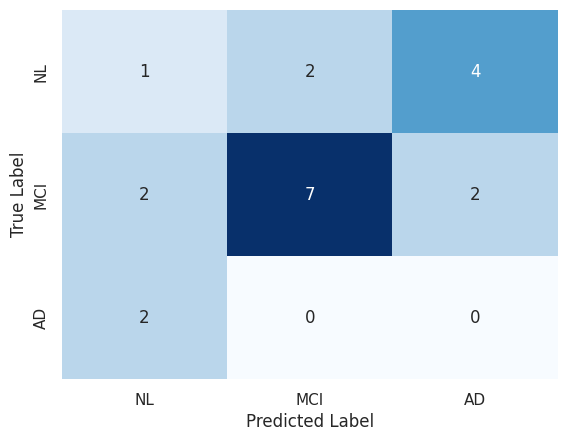

In [22]:
# Create a confusion matrix as a 2D array.
confusion_matrix_X = tf.math.confusion_matrix(xlabel_test, test_predictions_X)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix_X, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_lst, yticklabels=label_lst, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [26]:
from sklearn.metrics import precision_score
precision = precision_score(xlabel_test, test_predictions_X, average='weighted')
precision

0.49777777777777776

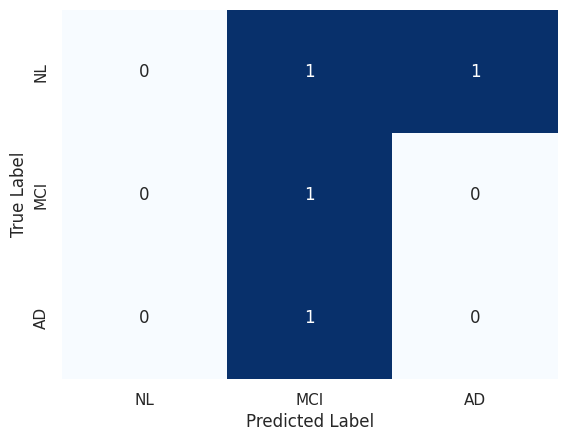

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix_Y = tf.math.confusion_matrix(ylabel_test, test_predictions_Y)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix_Y, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_lst, yticklabels=label_lst, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [ ]:
data_file = "/content/drive/MyDrive/DATASCI207_Project/DXSUM_PDXCONV_ADNIALL_23Oct2023.csv"
df_diagnosis = pandas.read_csv(data_file)

In [ ]:
# Use ADNI 1 data only.
df_diagnosis = df_diagnosis[df_diagnosis['Phase'] == 'ADNI1']
df_diagnosis.columns

Index(['Phase', 'ID', 'RID', 'PTID', 'SITEID', 'VISCODE', 'VISCODE2',
       'VISDATE', 'USERDATE', 'USERDATE2', 'EXAMDATE', 'DXCHANGE', 'DXCURREN',
       'DXCONV', 'DXCONTYP', 'DXREV', 'DXNORM', 'DXNODEP', 'DXMCI', 'DXMDES',
       'DXMPTR1', 'DXMPTR2', 'DXMPTR3', 'DXMPTR4', 'DXMPTR5', 'DXMPTR6',
       'DXMDUE', 'DXMOTHET', 'DXDSEV', 'DXDDUE', 'DXAD', 'DXADES', 'DXAPP',
       'DXAPROB', 'DXAPOSS', 'DXPARK', 'DXPDES', 'DXPCOG', 'DXPATYP', 'DXDEP',
       'DXOTHDEM', 'DXODES', 'DXCONFID', 'DIAGNOSIS', 'update_stamp'],
      dtype='object')

In [ ]:
data_symptoms = "/content/drive/MyDrive/DATASCI207_Project/ADSXLIST_25Oct2023.csv"
df_symptoms = pandas.read_csv(data_file)